In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
df1 = pd.read_csv('datasets/d_tweets.csv')
df2 = pd.read_csv('datasets/non_d_tweets.csv')
df3 = pd.read_csv('datasets/positive_user.csv')
df4 = pd.read_csv('datasets/negative_user.csv')

In [4]:
df1 = pd.DataFrame({'text':df1['tweet'], 'label': [1]*len(df1), 'user' : df1['username']})
df2 = pd.DataFrame({'text':df2['tweet'], 'label': [0]*len(df2), 'user' : df2['username']})

In [5]:
print(len(df1), len(df2), len(df3), len(df4))

3496 4809 459011 2726520


In [6]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [8]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words

nltk.download(['wordnet', 'stopwords', 'punkt', 'words'])

stop = set(stopwords.words('english'))
real = set(words.words())
l = WordNetLemmatizer()
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text
def process(text):
    text=re.sub(r'\s+',' ',text, flags=re.I)
    #remove spl characters other than A-Z,a-z,0-9 or _
    text=re.sub(r'\W',' ',text)
    
    #remove single character
    text=re.sub(r'\s+[a-zA-Z]\s+',' ',text)
    
    #remove character not alphabetical
    text=re.sub(r'[^a-zA-Z\s]','',text)
    
    text=text.lower()
    
    words= word_tokenize(text)
    
    #words=[l.lemmatize(i) for i in words]
    Words=[word for word in words if word not in stop and word in real]
    Words = [convert_abbrev(word) for word in Words]
    #Words = [' '.join(Words[i:i+2]) for i in range(len(Words)-1)]
    
    #removing duplicate words
    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()
    
    return cleaned_text


[nltk_data] Downloading package wordnet to /home/jamesli/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jamesli/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jamesli/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /home/jamesli/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [9]:
pos = pd.concat([df1,df3])
neg = pd.concat([df2,df4])
print(len(neg['user'].unique()),len(pos['user'].unique()))

4730 2490


In [10]:
neg = neg[neg['text'].str[:2] != 'RT']
pos = pos[pos['text'].str[:2] != 'RT']

In [11]:
x = neg.groupby('user')['text'].agg(list).reset_index()

In [12]:
x['text'] = [[' '.join(process(j))  for j in i[:10]] for i in x['text']]

x['label'] = [0]*len(x)

In [13]:
y = pos.groupby('user')['text'].agg(list).reset_index()
y['text'] = [[' '.join(process(j)) for j in i[:10]] for i in y['text']]

y['label'] = [1]*len(y)

In [14]:
df = pd.concat([x[:2450], y[:2450]])
df.columns = ['user', 'text', 'label']

In [15]:
df['text'] = ["[CLS] " + " [CLS] ".join([j for j in i if len(j) > 0]) + " [CLS]" for i in df['text']]

In [16]:
df

,user,text,label
0,0111_i_,[CLS] good night [CLS] thank [CLS],0
1,0925z0112,[CLS] look forward day come back japan [CLS],0
2,0I1I1I0,[CLS] really would great [CLS] thank study [CL...,0
3,0White_prayer0,[CLS] let match one [CLS] welcome hopefully st...,0
4,0i843,[CLS] put password person love [CLS] love fore...,0
...,...,...,...
2445,xAmberBrooks,[CLS] first time long breakdown public [CLS] f...,1
2446,xJessieOfTruth,[CLS] finally coming get see real [CLS] jealou...,1
2447,xMichelax,[CLS] many people never understand joy learnin...,1
2448,xOutcast_Ninjax,[CLS] lost best friend love death physically m...,1


In [17]:
'''
#for individual texts
arr = []

for i in df.values:
    for j in i[1]:
        if len(j) > 0:
            arr.append([i[0], j, i[2]])
df = pd.DataFrame(arr)
df.drop_duplicates(inplace=True)
df.columns = ['user','text', 'label']
'''

"\n#for individual texts\narr = []\n\nfor i in df.values:\n    for j in i[1]:\n        if len(j) > 0:\n            arr.append([i[0], j, i[2]])\ndf = pd.DataFrame(arr)\ndf.drop_duplicates(inplace=True)\ndf.columns = ['user','text', 'label']\n"

In [18]:
cloud = []
for i in df['text']:
    for x in i:
        for j in x.split():
            cloud.append(x)

In [19]:
np.pad(df['text'].iloc[0],pad_width=10, constant_values='')

array('[CLS] good night [CLS] thank [CLS]', dtype='<U34')

In [20]:
from wordcloud import WordCloud
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(cloud))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [21]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(3920, 3) (490, 3) (490, 3)


In [22]:
# Plot the distribution
class_names = ['not depressed', 'depressed']

In [23]:
from torch.nn.utils.rnn import pad_sequence
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, force_download=True)

class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    targets = torch.stack([item['targets'] for item in batch])

    # Pad sequences to the same length within the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'targets': targets
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),  # Assuming the text column contains lists of strings as string representations
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0#,
        #collate_fn=collate_fn
    )

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [24]:

# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

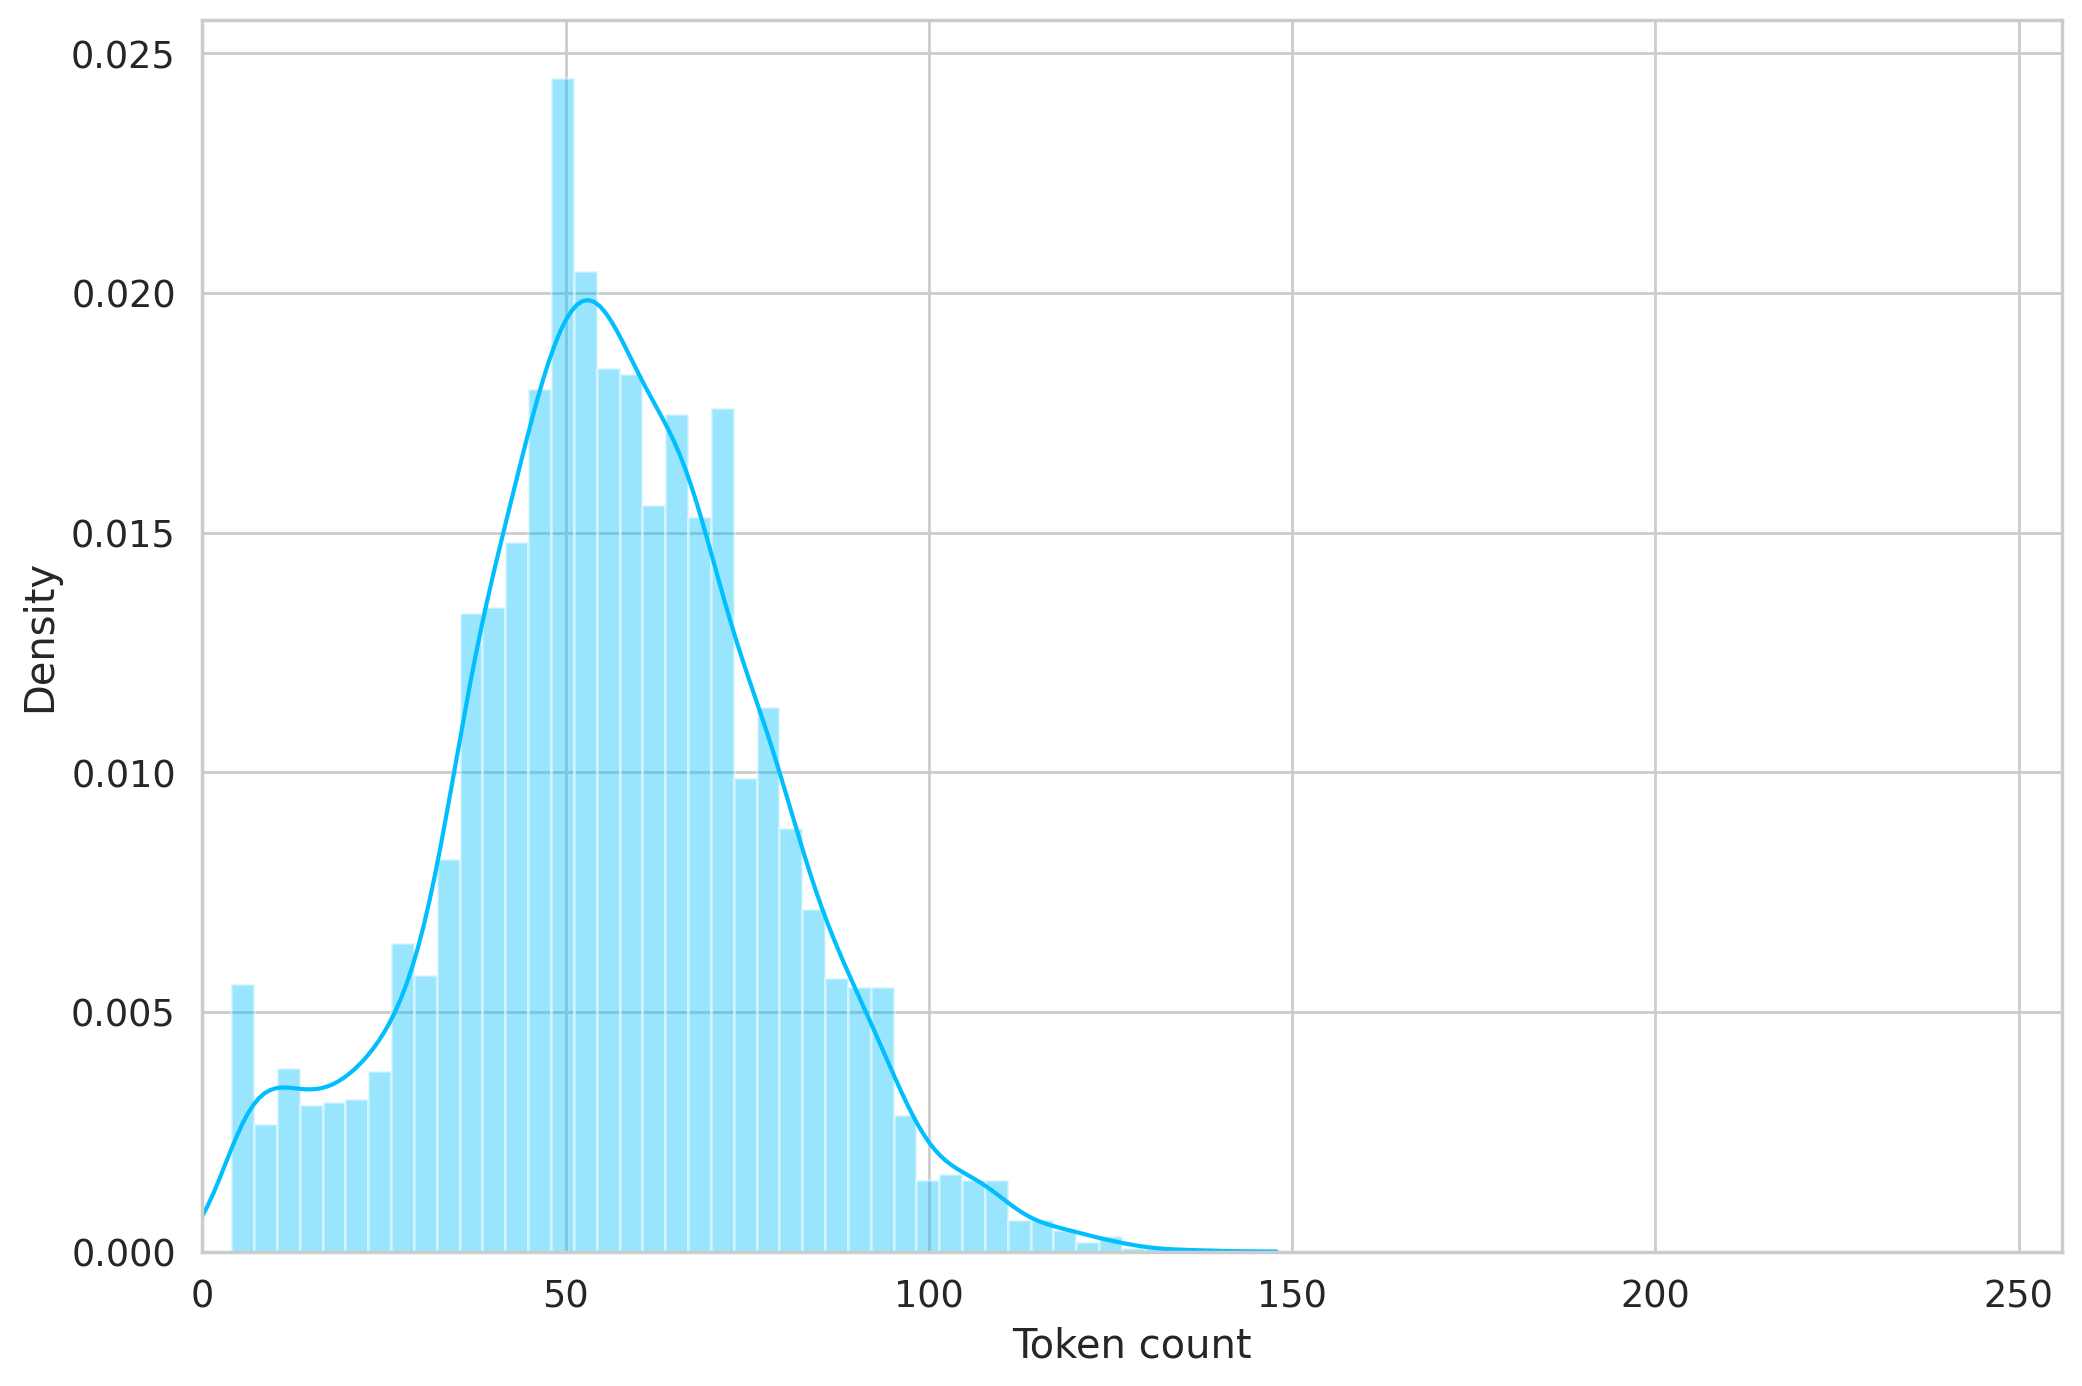

In [25]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [26]:
MAX_LEN = 150

In [27]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

all_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

In [28]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [29]:
data

{'review_text': ['[CLS] sigh since sleep think mud carnival withdrawal metropolis [CLS] unlocked school night badge foursquare [CLS] mas till next year sigh time soak old metropolis [CLS] time get ready hit road full force cause ah bliss let metropolis [CLS] warming take advantage tomorrow [CLS] today pure bliss real ah miss tribe tomorrow metropolis [CLS] sunny day port thick air time get take advantage people say come [CLS] full day pon di road sleep diamond vale breakfast metropolis [CLS] chilling carnival still far care come [CLS] pure bliss [CLS]',
  '[CLS] many training [CLS] even security job grateful really bad reach n [CLS] exorbitant data voice poor service delivery success story [CLS] palm oil cancer [CLS] leadership army sheep led lion defeat proverb [CLS] code suspended [CLS] narcissistic key word [CLS] code suspended know you stupid nonsensical priesthood eternal bishop [CLS] thanks recent follow happy connect great [CLS] event [CLS]',
  '[CLS] still think brilliant idea 

In [30]:
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [31]:
'''
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
      pooled_output = []
      for x in input_ids:
        output = self.bert(input_ids=x,attention_mask=attention_mask,return_dict=False)
        output = self.drop(pooled_output)
        pooled_output.append(self.out(output))


      return np.mean(pooled_output)
'''
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [103]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)
model.cuda()

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [104]:
len(df)

4900

In [105]:
EPOCHS = 6
# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [106]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, progress_bar=None):
    model = model.train()
    losses = []
    correct_predictions = 0

    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if progress_bar:
            progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)

In [107]:
def eval_model(model, data_loader, loss_fn, device, n_examples, progress_bar=None):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            # Update progress bar
            if progress_bar:
                progress_bar.update(1)

    return correct_predictions / n_examples, np.mean(losses)

In [108]:
#send to GPU
model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [109]:
%%time
from tqdm import tqdm


EPOCHS = 2


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Initialize the progress bar for training
    train_progress_bar = tqdm(total=len(train_data_loader), desc="Training", position=0, leave=True)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        train_progress_bar  # Pass the progress bar to your train_epoch function
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    
    # Initialize the progress bar for validation
    val_progress_bar = tqdm(total=len(val_data_loader), desc="Validation", position=0, leave=True)

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        val_progress_bar  # Pass the progress bar to your eval_model function
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------


Training: 100%|███████████████████████████████| 245/245 [00:59<00:00,  3.73it/s]

Train loss 0.6356325241984153 accuracy 0.6474489795918368


Validation:  97%|██████████████████████████████ | 30/31 [00:03<00:00, 10.32it/s]

Val   loss 0.5711410401328918 accuracy 0.655102014541626

Epoch 2/2
----------


Training: 100%|███████████████████████████████| 245/245 [01:02<00:00,  3.64it/s]

Train loss 0.5800251991164928 accuracy 0.7040816326530613


Validation:  97%|██████████████████████████████ | 30/31 [00:03<00:00,  9.91it/s]

Val   loss 0.5782844039701647 accuracy 0.6959183216094971

CPU times: user 1min 43s, sys: 26 s, total: 2min 9s
Wall time: 2min 15s


In [110]:
i = 0
for param in model.parameters():
    if i < 6:
        param.requires_grad = False
    i += 1

In [ ]:
%%time
from tqdm import tqdm


EPOCHS = 4  # Example, set your number of epochs


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Initialize the progress bar for training
    train_progress_bar = tqdm(total=len(train_data_loader), desc="Training", position=0, leave=True)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        train_progress_bar  # Pass the progress bar to your train_epoch function
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    
    # Initialize the progress bar for validation
    val_progress_bar = tqdm(total=len(val_data_loader), desc="Validation", position=0, leave=True)

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        val_progress_bar  # Pass the progress bar to your eval_model function
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/4
----------


Training: 100%|███████████████████████████████| 245/245 [01:01<00:00,  4.07it/s]

Train loss 0.5154013154458027 accuracy 0.7477040816326531


Validation: 100%|███████████████████████████████| 31/31 [00:02<00:00, 12.16it/s]

Val   loss 0.5577521151111972 accuracy 0.7102040648460388

Epoch 2/4
----------


Training: 100%|███████████████████████████████| 245/245 [00:59<00:00,  4.25it/s]

Train loss 0.46325643719459064 accuracy 0.7951530612244899


Validation:  97%|██████████████████████████████ | 30/31 [00:02<00:00, 11.66it/s]

Val   loss 0.5681535784275301 accuracy 0.7285714149475098

Epoch 3/4
----------


Training: 100%|███████████████████████████████| 245/245 [00:59<00:00,  4.27it/s]

Train loss 0.39830537076507294 accuracy 0.8321428571428572


Validation:  97%|██████████████████████████████ | 30/31 [00:02<00:00, 11.04it/s]

Val   loss 0.6141424121395234 accuracy 0.7224489450454712

Epoch 4/4
----------


Training:  41%|████████████▋                  | 100/245 [00:25<00:33,  4.27it/s]

In [81]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [83]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

<Axes: >

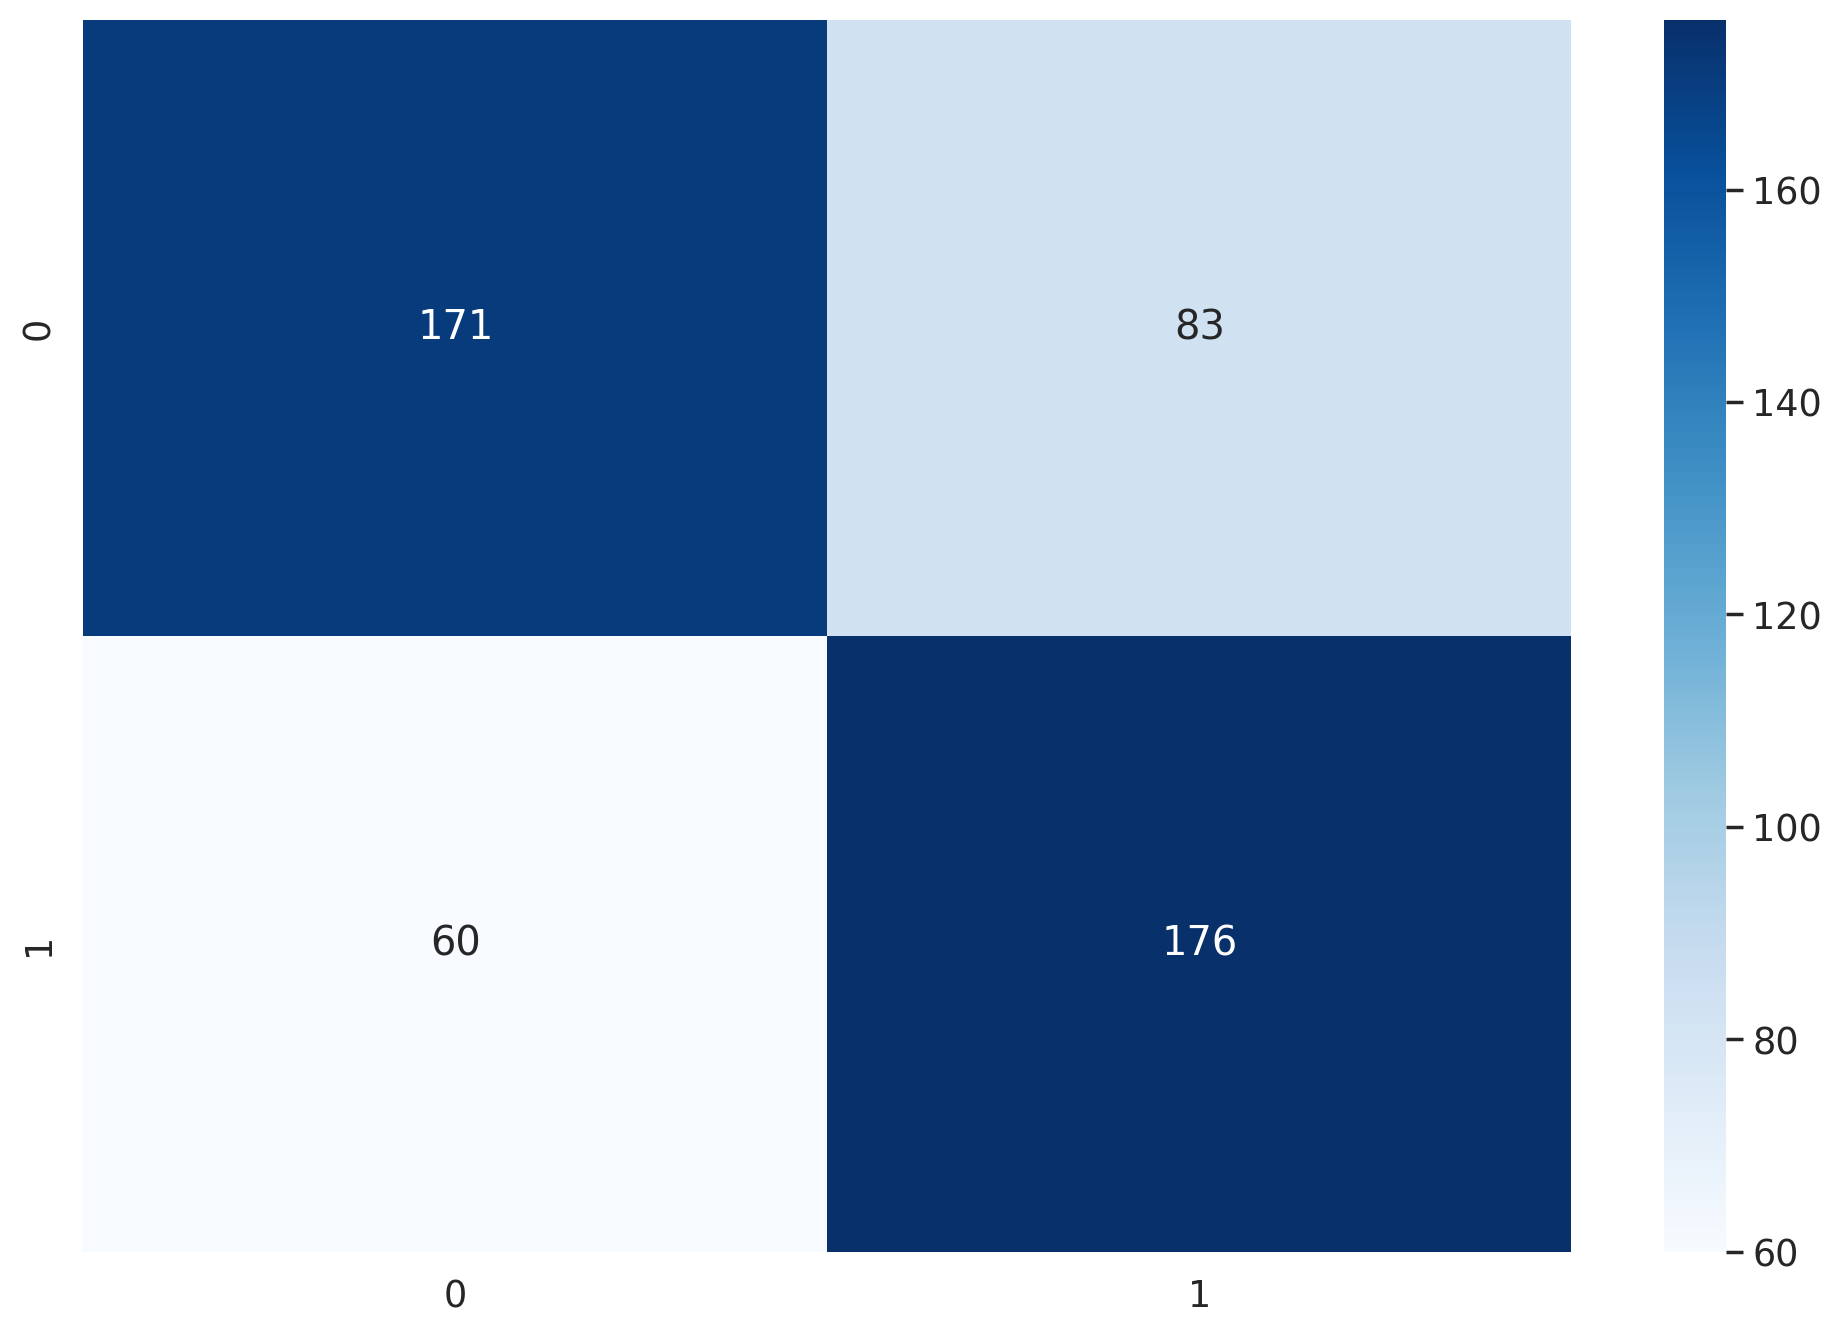

In [84]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap = 'Blues', fmt='g')

In [85]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not depressed       0.74      0.67      0.71       254
    depressed       0.68      0.75      0.71       236

     accuracy                           0.71       490
    macro avg       0.71      0.71      0.71       490
 weighted avg       0.71      0.71      0.71       490



Validation: 100%|███████████████████████████████| 31/31 [00:20<00:00, 12.16it/s]

In [62]:
torch.save(model.state_dict(), "somehow_74.pt")